In machine learning, most of the time needs to be in data representation, which is known as Feature Engineering. Need to represent the raw data in certain form that the machine learning algorithm understands.

Feature engineering is transforming the raw data into feature vector.

Represent the categorical data using one hot encoding.

Scaling: scaling of features means, converting floating point values of data in the original range into a standard range of say 0 to 1 or -1 to +1. 
Advantages are:
* Helps faster convergence.
* Avoids NaN traps.
* Helps model to learn appropriate weights for each feature.


In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [3]:
california_housing_dataframe = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv', sep=',')
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
5667,-118.2,33.9,44.0,1890.0,465.0,1378.0,430.0,3.9,143200.0
8459,-118.5,34.1,29.0,4767.0,777.0,1500.0,638.0,10.8,500001.0
1667,-117.2,33.2,9.0,2486.0,626.0,1938.0,525.0,2.1,151400.0
7152,-118.3,33.8,29.0,3254.0,717.0,1593.0,680.0,4.1,285800.0
9437,-119.2,36.2,24.0,2015.0,355.0,1031.0,351.0,3.4,139200.0


In [4]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe64bb35908>]],
      dtype=object)

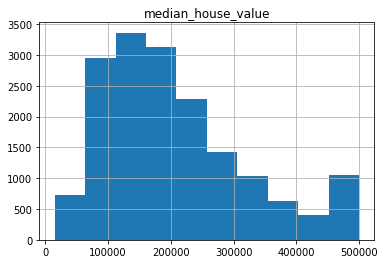

In [6]:
california_housing_dataframe.hist('median_house_value')

In [0]:
def preprocess_features(cfd):
  '''
  select features to train the model
  cfd - california housing dataframe
  '''

  selected_features = cfd[["latitude", "longitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", "median_income"]]

  processed_features = selected_features.copy()

  processed_features['rooms_per_person'] = processed_features['total_rooms'] / processed_features['population']

  return processed_features

In [0]:
def preprocess_targets(cfd):
  '''
  preprocess the target label
  cfd - california housing dataframe
  '''

  target = pd.DataFrame()
  target['median_house_value'] = cfd['median_house_value'] / 1000.0

  return target

In [11]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

print('training example summary')
display.display(training_examples.describe())
print('training target summary')
display.display(training_targets.describe())

print('validation example summary')
display.display(validation_examples.describe())
print('validation target summary')
display.display(validation_targets.describe())

training example summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2634.1,538.3,1426.8,499.6,3.9,2.0
std,2.1,2.0,12.6,2146.4,417.9,1143.9,380.6,1.9,1.0
min,32.5,-124.3,1.0,2.0,2.0,3.0,2.0,0.5,0.0
25%,33.9,-121.8,18.0,1463.0,296.0,789.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2123.0,434.0,1165.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3142.0,649.2,1716.0,603.2,4.7,2.3
max,42.0,-114.5,52.0,32054.0,5290.0,35682.0,5050.0,15.0,41.3


training target summary


,median_house_value
count,12000.0
mean,206.3
std,115.8
min,15.0
25%,118.8
50%,178.9
75%,263.3
max,500.0


validation example summary


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.6,2666.6,542.1,1436.2,505.1,3.9,2.0
std,2.1,2.0,12.6,2258.5,430.1,1157.5,393.8,1.9,1.5
min,32.5,-124.3,2.0,8.0,1.0,13.0,1.0,0.5,0.1
25%,33.9,-121.8,18.0,1453.8,299.0,791.8,283.0,2.6,1.5
50%,34.3,-118.5,29.0,2143.0,433.5,1172.0,410.0,3.6,1.9
75%,37.7,-118.0,37.0,3171.2,647.0,1738.0,609.0,4.8,2.3
max,41.9,-114.3,52.0,37937.0,6445.0,28566.0,6082.0,15.0,55.2


validation target summary


,median_house_value
count,5000.0
mean,209.8
std,116.5
min,15.0
25%,122.0
50%,183.2
75%,268.8
max,500.0


In [13]:
correlation_dataframe = training_examples.copy()
correlation_dataframe['target'] = training_targets['median_house_value']

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.2,-0.1
longitude,-0.9,1.0,-0.1,0.1,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.1,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.2,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.3,0.7
rooms_per_person,0.2,-0.1,-0.1,0.1,0.1,-0.2,-0.0,0.3,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


In [0]:
def construct_feature_columns(input_features):
  '''
  creates the feature columns
  '''
  return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, epochs = None):
  '''
  returns processed features and labels
  features - features to process
  targets - target labels
  batch_size - batch size
  shuffle - shuffle the data
  epochs - number of epochs to repeat
  '''

  features = {key:value for key, value in dict(features).items()}
  # print(features)

  ds = Dataset.from_tensor_slices((features, targets))
  ds = ds.batch(batch_size).repeat(epochs)

  if shuffle:
    ds = ds.shuffle(10000)

  features, targets = ds.make_one_shot_iterator().get_next()

  return features, targets

In [0]:
def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):

  '''
  returns linear regressor model
  learning rate - learning rate for training model
  steps - steps of training
  batch size - number of batches
  training examples - preprocessed training examples
  training targets - preprocessed training targets
  validation examples - preprocessed validation examples
  validation targets - preprocessed validation targets
  '''

  periods = 10
  steps_per_period = steps / periods

  # creating my optimizer
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)

  # creation of input functions
  training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'], batch_size, shuffle=True, epochs=None)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets['median_house_value'], shuffle=False, epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets['median_house_value'], shuffle=False, epochs=1)

  print('training started')
  print('RMSE on training data')
  training_RMSE = []
  validation_RMSE = []

  for period in range(periods):

    linear_regressor.train(input_fn = training_input_fn, steps=steps_per_period)

    prediction_training = linear_regressor.predict(input_fn = predict_training_input_fn)
    prediction_training = np.array([item['predictions'][0] for item in prediction_training])

    prediction_validation = linear_regressor.predict(input_fn=predict_validation_input_fn)
    prediction_validation = np.array([item['predictions'][0] for item in prediction_validation])

    training_rmse = math.sqrt(metrics.mean_squared_error(prediction_training, training_targets))
    print("  period %02d training rmse: %0.2f" % (period, training_rmse))

    validation_rmse = math.sqrt(metrics.mean_squared_error(prediction_validation, validation_targets))
    print("  period %02d  validation rmse: %0.2f" % (period, validation_rmse))

    training_RMSE.append(training_rmse)
    validation_RMSE.append(validation_rmse)

  print('training complete')

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_RMSE, label="training")
  plt.plot(validation_RMSE, label="validation")
  plt.legend()

  return linear_regressor

training started
RMSE on training data
  period 00 training rmse: 228.78
  period 00  validation rmse: 232.17
  period 01 training rmse: 221.13
  period 01  validation rmse: 224.48
  period 02 training rmse: 213.58
  period 02  validation rmse: 216.89
  period 03 training rmse: 206.14
  period 03  validation rmse: 209.41
  period 04 training rmse: 198.83
  period 04  validation rmse: 202.05
  period 05 training rmse: 191.66
  period 05  validation rmse: 194.82
  period 06 training rmse: 184.65
  period 06  validation rmse: 187.75
  period 07 training rmse: 177.81
  period 07  validation rmse: 180.85
  period 08 training rmse: 171.18
  period 08  validation rmse: 174.13
  period 09 training rmse: 164.76
  period 09  validation rmse: 167.64
training complete


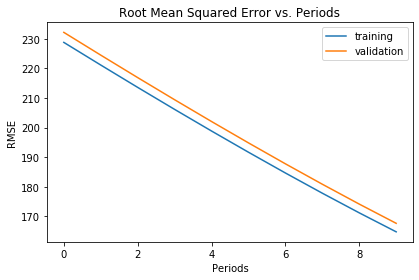

In [27]:
minimal_features = ["median_income", "latitude"]

minimal_feature_examples = trainging_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

linear_regressor = train_model(0.001, 500, 5, minimal_feature_examples, training_targets, minimal_validation_examples, validation_targets)